### Imports

In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [2]:
import logging
logger = logging.getLogger('VEHICLE_DET')
hdlr = logging.FileHandler('./vehicle_det.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.DEBUG)

### Data Exploration

In [3]:
car_images = glob.glob('./training_data/vehicles/*/*/*.png')
noncar_images = glob.glob('./training_data/non_vehicles/*/*/*.png')

In [4]:
from vehicle_detection import data_analysis

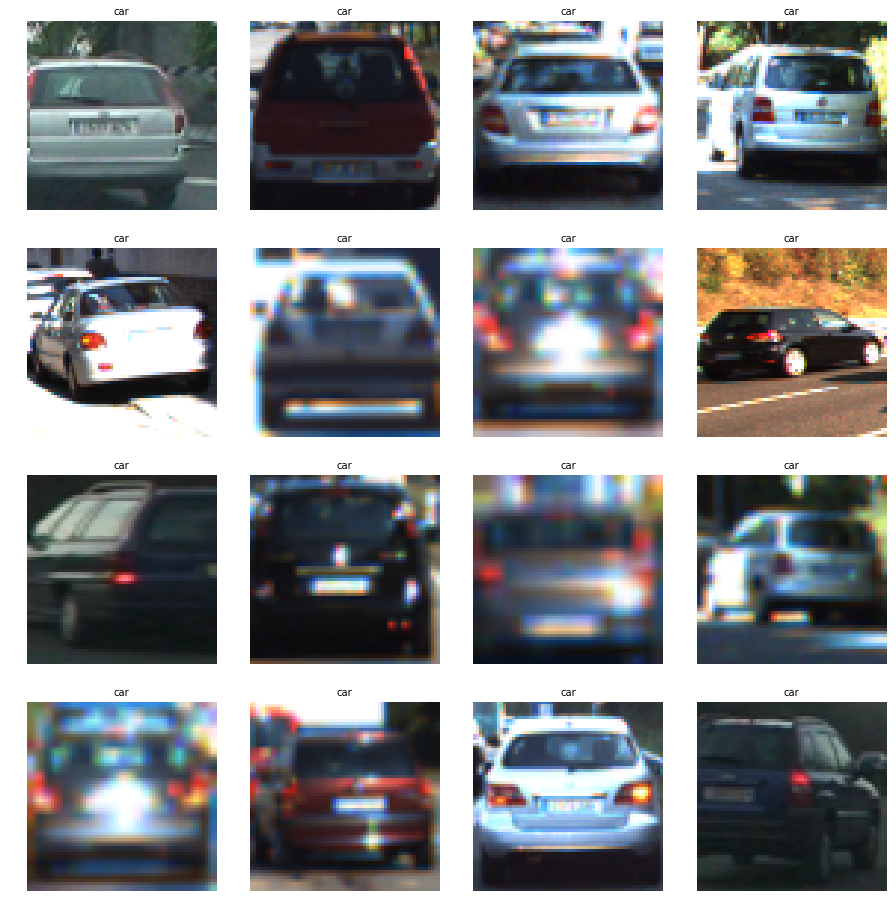

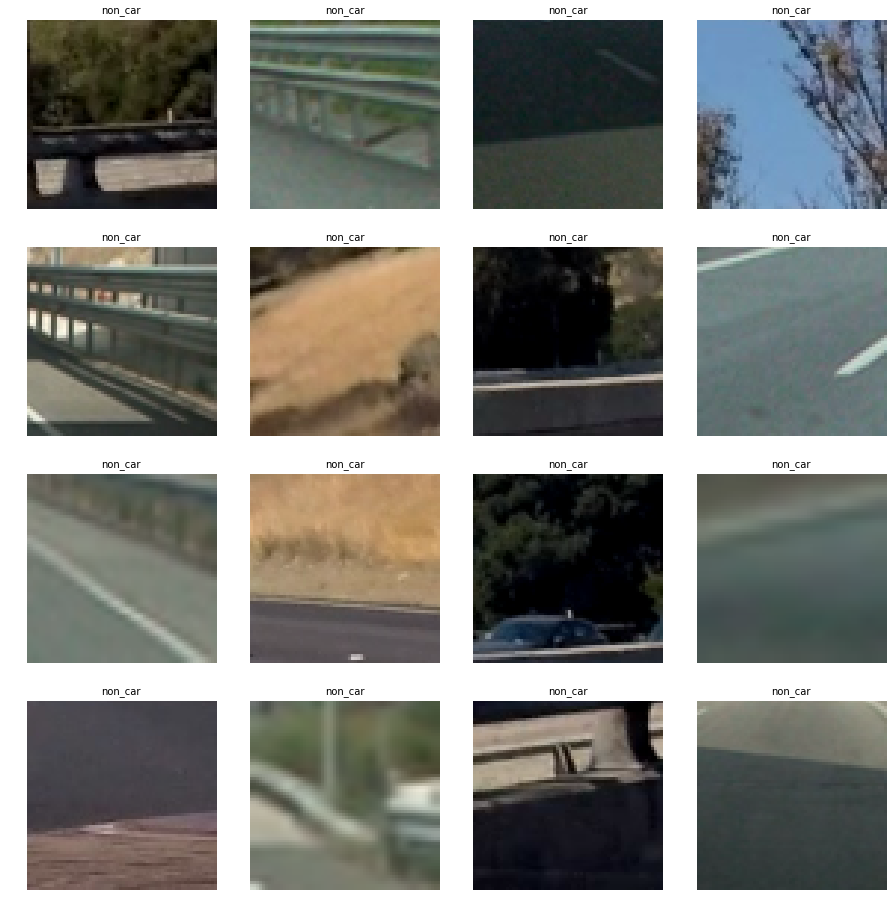

In [5]:
data_dict = data_analysis.explore_input_images(car_images, noncar_images, 16)

### Feature Extraction

In [6]:
from vehicle_detection import feature_extraction as feature

##### Hog Parameters

In [7]:
g_orient = 9
g_pix_per_cell = 8
g_cell_per_block = 2

##### Apply HOG on a random car and noncar image

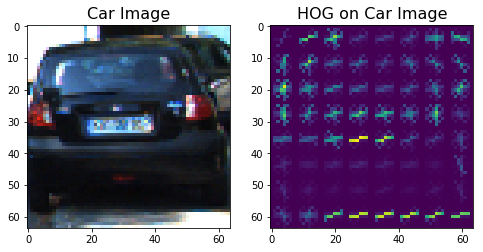

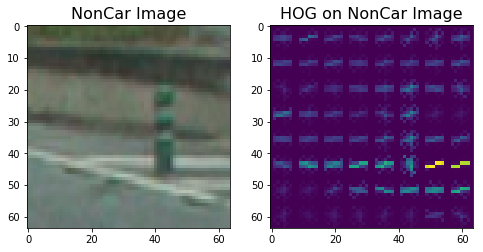

In [8]:
c_index = np.random.randint(0,len(car_images))
car_img = mpimg.imread(car_images[c_index])
car_features, car_hog = feature.get_hog_features(car_img[:,:,2], g_orient, g_pix_per_cell, g_cell_per_block, vis=True, feature_vec=True)
nonc_index = np.random.randint(0,len(noncar_images))
noncar_img = mpimg.imread(noncar_images[nonc_index])
noncar_features, noncar_hog = feature.get_hog_features(noncar_img[:,:,2], g_orient, g_pix_per_cell, g_cell_per_block, vis=True, feature_vec=True)
data_analysis.plot_as_subplots(car_img, car_hog, 'Car Image', 'HOG on Car Image')
data_analysis.plot_as_subplots(noncar_img, noncar_hog, 'NonCar Image', 'HOG on NonCar Image')

### Data Preparation for Classifier

In [9]:
from vehicle_detection import classifier

##### List of values every parameter can take

In [10]:
### TODO: Tweak these parameters and see how the results change.
g_colorspace = ['RGB', 'HSV', 'YUV']# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
g_orient = [9, 10, 11, 12]
g_pix_per_cell = [8, 16]
g_cell_per_block = [1, 2, 4]
g_hog_channel = [0, 1, 2, "ALL"] # Can be 0, 1, 2, or "ALL"

##### Function to perform an exhasutive search, I have limited color space to YUV, RGB and HLS now from previous insights

In [11]:
def hog_param_exploration(hog_param_df, colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    hog_params = {}
    count  = 0
    for color in g_colorspace:
        for orientation in orient:
            for pixel in pix_per_cell:
                for cell in cell_per_block:
                    for channel in hog_channel:
                        hog_params['cspace'] = color
                        hog_params['orient'] = orientation
                        hog_params['pix_per_cell'] = pixel
                        hog_params['cell_per_block'] = cell
                        hog_params['hog_channel'] =  channel
                        new_hog = pd.DataFrame(hog_params, index = [count])
                        _, hog_svc_data = classifier.train_hog_features(car_images, noncar_images, hog_params, logger)
                        new_svc = pd.DataFrame(hog_svc_data, index = [count])
                        hog_svc_df = pd.concat([new_hog, new_svc], axis=1)
                        hog_param_df = hog_param_df.append(hog_svc_df)
                        count = count + 1
    display(hog_param_df)
    return hog_param_df

##### Create a dataframe of results from all runs on classifying each configuration with SVC

In [12]:
hog_param_df = pd.DataFrame(columns=['cspace', 'orient', 'pix_per_cell', 'cell_per_block', 'hog_channel', 
                                     'feature_extraction_time', 'training_time', 'accuracy', 'prediction_time'])
hog_param_df = hog_param_exploration(hog_param_df, g_colorspace, g_orient, g_pix_per_cell, g_cell_per_block, g_hog_channel)

,accuracy,cell_per_block,cspace,feature_extraction_time,hog_channel,orient,pix_per_cell,prediction_time,training_time
0,0.9361,1,RGB,23.57,0,9,8,0.0,5.35
1,0.9488,1,RGB,23.91,1,9,8,0.0,4.27
2,0.9488,1,RGB,24.12,2,9,8,0.0,3.91
3,0.9581,1,RGB,61.17,ALL,9,8,0.0,7.54
4,0.9524,2,RGB,29.85,0,9,8,0.0,3.75
5,0.9690,2,RGB,30.09,1,9,8,0.0,3.37
6,0.9611,2,RGB,30.34,2,9,8,0.0,3.31
7,0.9735,2,RGB,79.16,ALL,9,8,0.0,15.79
8,0.9510,4,RGB,35.23,0,9,8,0.0,5.21
9,0.9561,4,RGB,31.12,1,9,8,0.0,4.85


##### Save the result dataframe to a csv, to prevent running these cells again.
##### Further steps to identify best configuration can be done by loading the csv file, if notebook needs restarting

In [16]:
!pip install openpyxl
writer = pd.ExcelWriter('hog_param_exploration.xlsx')
hog_param_df.to_excel(writer,'Sheet1')
writer.save()

  Running setup.py bdist_wheel for openpyxl: started
  Running setup.py bdist_wheel for openpyxl: finished with status 'done'
  Stored in directory: C:\Users\jummp01\AppData\Local\pip\Cache\wheels\8d\ae\96\0b8e7890053c46c22b48d021d104b00e5544c3aedd641749e1
  Running setup.py bdist_wheel for jdcal: started
  Running setup.py bdist_wheel for jdcal: finished with status 'done'
  Stored in directory: C:\Users\jummp01\AppData\Local\pip\Cache\wheels\0f\63\92\19ac65ed64189de4d662f269d39dd08a887258842ad2f29549
  Running setup.py bdist_wheel for et-xmlfile: started
  Running setup.py bdist_wheel for et-xmlfile: finished with status 'done'
  Stored in directory: C:\Users\jummp01\AppData\Local\pip\Cache\wheels\99\f6\53\5e18f3ff4ce36c990fa90ebdf2b80cd9b44dc461f750a1a77c
Successfully built openpyxl jdcal et-xmlfile


##### Get top 5 accuracy configurations

In [20]:
best_accuracy_df = hog_param_df.nlargest(5, 'accuracy')
display(best_accuracy_df)

,accuracy,cell_per_block,cspace,feature_extraction_time,hog_channel,orient,pix_per_cell,prediction_time,training_time
127,0.9868,2,HSV,75.14,ALL,10,8,0.0,6.20
175,0.9865,2,HSV,59.82,ALL,12,8,0.0,5.35
235,0.9862,2,YUV,37.56,ALL,10,16,0.0,0.71
251,0.9859,4,YUV,50.22,ALL,11,8,0.0,9.64
223,0.9854,2,YUV,77.68,ALL,10,8,0.0,5.61


##### 235 shows very small training time relatively, check if it makes sense, find smallest training times

In [23]:
best_training_time_df = hog_param_df.nsmallest(5, 'training_time')
display(best_training_time_df)

,accuracy,cell_per_block,cspace,feature_extraction_time,hog_channel,orient,pix_per_cell,prediction_time,training_time
21,0.9234,4,RGB,14.37,1,9,16,0.0,0.18
22,0.9257,4,RGB,14.33,2,9,16,0.0,0.18
118,0.9251,4,HSV,14.53,2,9,16,0.0,0.18
212,0.9302,4,YUV,14.12,0,9,16,0.0,0.18
20,0.9240,4,RGB,14.33,0,9,16,0.0,0.19


#### WINNER!

We have a clear winner considering the accuracy and training time in the best_accuracy_df, which is configuration index 235.

    g_colorspace = 'YUV'
    g_orient = 10
    g_pix_per_cell = 16
    g_cell_per_block = 2
    g_hog_channel = "ALL"

## Note: Continue to video_detection_sliding_window notebook taking these parameters! 